In [1]:
import os
import json
import torch
import einops
import argparse
import numpy as np
import pandas as pd
import pickle as pkl
import os.path as op
from tqdm import tqdm
from skimage import io
from matplotlib import cm
from tensorly import norm
from torch.optim import Adam
import pytorch_lightning as pl
from capsules.capsules import *
from skimage.transform import resize
from torchvision import models, transforms
from torch.nn.functional import tanh, sigmoid
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score, roc_curve
from torch.nn import Conv2d, ReLU, ELU, LeakyReLU, Conv1d
from torch.nn import Sequential, Linear, Tanh, Sigmoid, MSELoss

In [2]:
from models import *
from data_module import *
from train_model import *
from compute_metrics import *

In [3]:
from matplotlib.patches import Patch

In [4]:
output_filename = "../models/KMNIST_CN_SDI_9_0.1.pt"

In [5]:
batch_size = BATCH_SIZES["KMNIST"]
transforms = TRANSFORMS["KMNIST"]
dm = DM(
    PATHS["KMNIST"][0], 
    PATHS["KMNIST"][1], 
    "SDI_9", 0.1, transforms, 
    batch_size=16, use_indices=False
)
model = MODELS["S"]["CN"]["KMNIST"]().to(0)
model.load_state_dict(
    torch.load(
        output_filename.replace(".csv", ".pt")
    )
)
dm.prepare_data()
dm.setup()
dm.train_dataloader()
dm.test_dataloader()

Train size (60000, 33)
Test size (10000, 33)
Final train size 60000
Final test size 10000
Final val size 10000


In [6]:
normal_indices = np.where(dm.test.labels == 0)[0]
anomal_indices = np.where(dm.test.labels == 1)[0]

In [7]:
couplings_normal = model(
    torch.FloatTensor(dm.test[normal_indices[0]][0].reshape(1,1,28,28)).cuda()
)[-1].squeeze()

In [8]:
couplings_anomal = model(
    torch.FloatTensor(dm.test[anomal_indices[0]][0].reshape(1,1,28,28)).cuda()
)[-1].squeeze()

In [9]:
import matplotlib
import matplotlib.pyplot as plt

In [10]:
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

/tmp/ipykernel_7923/2408035591.py:2: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


In [11]:
normal_G = apply_to_couplings(couplings_normal.reshape(1,2,1152,16), G).squeeze()[1]
anomal_G = apply_to_couplings(couplings_anomal.reshape(1,2,1152,16), G).squeeze()[1]
normal_P = apply_to_couplings(couplings_normal.reshape(1,2,1152,16), Palma).squeeze()[1]
anomal_P = apply_to_couplings(couplings_anomal.reshape(1,2,1152,16), Palma).squeeze()[1]

In [12]:
normal_Gn = apply_to_couplings(couplings_normal.reshape(1,2,1152,16), G).squeeze()[0]
anomal_Gn = apply_to_couplings(couplings_anomal.reshape(1,2,1152,16), G).squeeze()[0]
normal_Pn = apply_to_couplings(couplings_normal.reshape(1,2,1152,16), Palma).squeeze()[0]
anomal_Pn = apply_to_couplings(couplings_anomal.reshape(1,2,1152,16), Palma).squeeze()[0]

In [14]:
normal_Dn = apply_to_couplings(couplings_normal.reshape(1,2,1152,16), varlog).squeeze()[0]
anomal_Dn = apply_to_couplings(couplings_anomal.reshape(1,2,1152,16), varlog).squeeze()[0]
normal_D = apply_to_couplings(couplings_normal.reshape(1,2,1152,16), varlog).squeeze()[1]
anomal_D = apply_to_couplings(couplings_anomal.reshape(1,2,1152,16), varlog).squeeze()[1]

/tmp/ipykernel_7923/3930581810.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


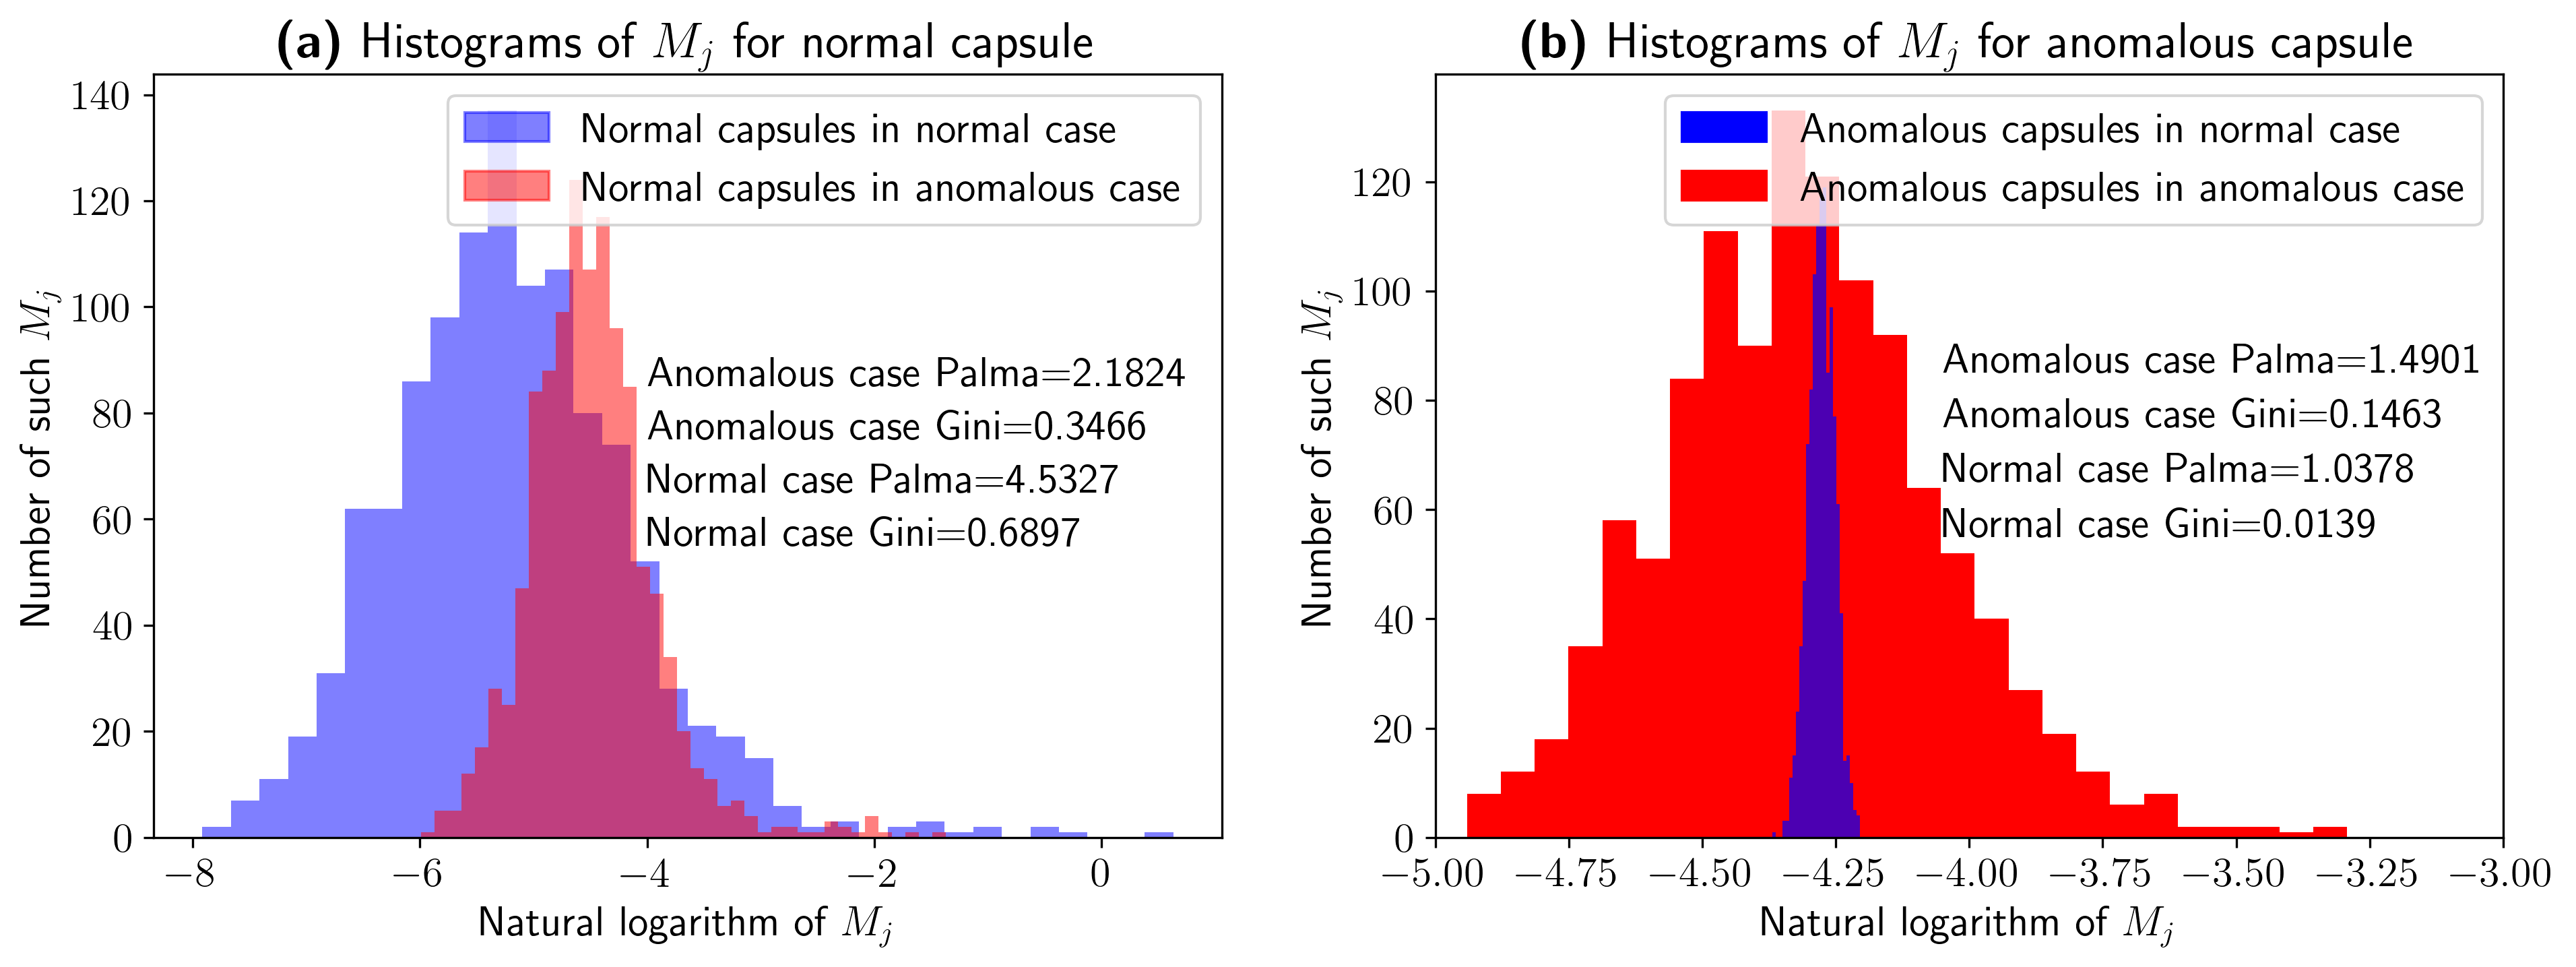

In [23]:
plt.rcParams["figure.figsize"] = 15,5
plt.rcParams["font.size"] = 15
plt.rcParams["figure.dpi"] = 300
fig, ax = plt.subplots(1,2)

ax[0].hist(np.log(np.sum(couplings_normal.squeeze()[0].T, 0)), bins="auto", color=(0,0,1,0.5))
ax[0].hist(np.log(np.sum(couplings_anomal.squeeze()[0].T, 0)), bins="auto", color=(1,0,0,0.5))
ax[0].legend(
    loc="best", handles=[
        Patch(label="Normal capsules in normal case", color=(0,0,1,0.5)),
        Patch(label="Normal capsules in anomalous case", color=(1,0,0,0.5)),
    ]
)
ax[0].set_title(r"$\textbf{(a)}$ Histograms of $M_j$ for normal capsule")
ax[0].set_xlabel(r"Natural logarithm of $M_j$")
ax[0].set_ylabel(r"Number of such $M_j$")


ax[0].annotate("Anomalous case Palma="+str(anomal_Pn.round(4)), xy=(-4, 85), xytext=(-4, 85))
ax[0].annotate("Anomalous case Gini="+str(anomal_Gn.round(4)), xy=(-4, 75), xytext=(-4, 75))
ax[0].annotate("Normal case Palma="+str(normal_Pn.round(4)), xy=(-4, 65), xytext=(-4, 65))
ax[0].annotate("Normal case Gini="+str(normal_Gn.round(4)), xy=(-4, 55), xytext=(-4, 55))

ax[1].hist(np.log(np.sum(couplings_anomal.squeeze()[1].T, 0)), bins="auto", color=(1,0,0,1))
ax[1].hist(np.log(np.sum(couplings_normal.squeeze()[1].T, 0)), bins="auto", color=(0,0,1,0.7))
ax[1].legend(
    loc="best", handles=[
        Patch(label="Anomalous capsules in normal case", color=(0,0,1,1)),
        Patch(label="Anomalous capsules in anomalous case", color=(1,0,0,1)),
    ]
)
ax[1].set_title(r"$\textbf{(b)}$ Histograms of $M_j$ for anomalous capsule")#summed coupling coefficients for anomalous capsule")
ax[1].set_xlabel(r"Natural logarithm of $M_j$")
ax[1].set_ylabel(r"Number of such $M_j$")#" summed coupling coefficients")# with such logaritmh")
ax[1].set_xlim((-5, -3))

ax[1].annotate("Anomalous case Palma="+str(anomal_P.round(4)), xy=(-4.05, 85), xytext=(-4.05, 85))
ax[1].annotate("Anomalous case Gini="+str(anomal_G.round(4)), xy=(-4.05, 75), xytext=(-4.05, 75))
ax[1].annotate("Normal case Palma="+str(normal_P.round(4)), xy=(-4.05, 65), xytext=(-4.05, 65))
ax[1].annotate("Normal case Gini="+str(normal_G.round(4)), xy=(-4.05, 55), xytext=(-4.05, 55))

fig.savefig("Figure2.png")
fig.savefig("Figure2.svg")

fig.show()